In [1]:
!pip install trainlog==0.2

import functools as ft
from pathlib import Path
from typing import Any, Dict, Iterable, Optional, Tuple

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tqdm
import torch as T
import torchvision
import trainlog as L

In [2]:
# # Colab-specific save to drive (optional)
# import google.colab
# google.colab.drive.mount("/content/drive")
# DRIVE_DIR = Path("drive/My Drive/Colab Notebooks/training_objectives")
# DRIVE_DIR.mkdir(exist_ok=True)
# Path("out").symlink_to(DRIVE_DIR)

In [3]:
##########################################
# Utilities

Batch = Tuple[T.Tensor, T.LongTensor]

def get_accuracy(model: T.nn.Module, n_classes: int, batches: Iterable[Batch]) -> float:
    """Compute the overall accuracy metric from test batches."""
    count, correct = 0, 0
    for inputs, labels in batches:
        count += int(labels.shape[0])
        outputs = model(inputs)[:, :n_classes]
        correct += int((labels == T.argmax(outputs, dim=-1)).sum())
    return correct / count

class ShallowModel(T.nn.Sequential):
    """An easy-to-train, slightly better than linear, shallow convolution model."""
    @staticmethod
    def _build(input_shape: Tuple[int, int, int], n_output: int) -> Iterable[T.nn.Module]:
        in_channels, height, width = input_shape
        channels = 64
        yield T.nn.Conv2d(in_channels, channels, 7, padding=3)
        yield T.nn.LeakyReLU()
        yield T.nn.Conv2d(channels, channels, 8, padding=3, stride=4)
        yield T.nn.LeakyReLU()
        yield T.nn.Flatten()
        yield T.nn.Linear(channels * height // 4 * width // 4, n_output)

    def __init__(self, input_shape: Tuple[int, int, int], n_output: int):
        super().__init__(*self._build(input_shape, n_output))

    def map_to_device(self, batches: Iterable[Batch]) -> Iterable[Batch]:
        device = next(iter(self.parameters())).device
        for x, y in batches:
            yield x.to(device), y.to(device)

In [4]:
##########################################
# Objectives

def softmax_cross_entropy(model: T.nn.Module,
                          inputs: T.Tensor,
                          labels: T.Tensor,
                          log: L.logger.LogLine) -> None:
    outputs = model(inputs)
    loss = T.nn.functional.cross_entropy(outputs, labels)
    loss.backward()
    log.set(loss=float(loss))

def teacher_student(model: T.nn.Module,
                    inputs: T.Tensor,
                    labels: T.Tensor,
                    log: L.logger.LogLine,
                    teacher: T.nn.Module,
                    alpha: float) -> None:
    device = inputs.device

    # 1. Mix teacher and student to get the target distribution
    with T.no_grad():
        soft_target = T.nn.functional.softmax(teacher(inputs), -1)
        hard_target = T.arange(soft_target.shape[-1], device=device) == labels[..., np.newaxis]
        target = alpha * soft_target + (1 - alpha) * hard_target

    # 2. Apply loss against mixed target
    outputs = model(inputs)
    logprobs = T.nn.functional.log_softmax(outputs, -1)
    loss = T.nn.functional.kl_div(logprobs, target, reduction="batchmean")
    loss.backward()
    log.set(loss=float(loss))

def sampled_softmax(model: T.nn.Module,
                    inputs: T.Tensor,
                    labels: T.Tensor,
                    log: L.logger.LogLine,
                    n_samples: int) -> None:
    batch_size = inputs.shape[0]
    device = inputs.device

    # 1. Generate predicted embeddings
    #
    # NOTE - we're cheating here - the projection should really be part of the model,
    # but we're replacing it with a "dummy" identity matrix - just to make this training
    # method fit in a bit more smoothly with the others
    #
    predicted_embeddings = model(inputs)
    n_classes = predicted_embeddings.shape[-1]
    projection = T.eye(n_classes, device=device)

    # 2. Get target label scores
    label_scores = (predicted_embeddings * projection[labels, :]).sum(-1)

    # 3. Sample shared noise & get scores
    samples = T.randint(high=n_classes, size=(n_samples,), device=device)
    noise_scores = predicted_embeddings @ projection[samples, :].T
    noise_scores += np.log(n_classes - 1)

    # 4. Reject samples matching target label & correct for remaining samples
    reject_samples = labels[:, np.newaxis] == samples[np.newaxis, :]
    noise_scores -= 1e6 * reject_samples
    noise_scores -= T.log((n_samples - reject_samples.sum(-1, keepdims=True)).float() + 1e-3)

    # 5. Apply regular softmax cross entropy
    scores = T.cat([label_scores[:, np.newaxis], noise_scores], dim=1)
    loss = T.nn.functional.cross_entropy(scores, T.zeros(batch_size, dtype=T.long, device=device))
    loss.backward()
    log.set(loss=float(loss))

def value_function(model: T.nn.Module,
                   inputs: T.Tensor,
                   labels: T.Tensor,
                   log: L.logger.LogLine,
                   epsilon: float) -> None:
    batch_size = inputs.shape[0]
    device = inputs.device

    # 1. Predict values for each possible action
    value_logits = model(inputs)

    # 2. Use a policy to select an action & obtain reward
    with T.no_grad():
        actions = T.where(
            T.rand(batch_size, device=device) < epsilon,
            T.randint(high=value_logits.shape[1], size=(batch_size,), device=device),
            T.argmax(value_logits, -1)
        )
        rewards = (actions == labels).float()

    # 3. Train the selected action's value
    action_value_logits = value_logits[T.arange(batch_size), actions]
    loss = T.nn.functional.binary_cross_entropy_with_logits(
        action_value_logits, rewards
    )
    loss.backward()
    log.set(loss=float(loss), reward=float(T.mean(rewards)))

def policy_gradient(model: T.nn.Module,
                    inputs: T.Tensor,
                    labels: T.Tensor,
                    log: L.logger.LogLine,
                    entropy_weight: float) -> None:
    batch_size = labels.shape[0]

    # 1. Generate a log-probability for each action and evaluate the baseline
    outputs = model(inputs)
    n_classes = outputs.shape[-1] - 1
    baseline = T.sigmoid(outputs[:, -1])
    log_probs = T.log_softmax(outputs[:, :n_classes], -1)

    with T.no_grad():
        # 2. Sample an action and obtain a reward
        actions = T.multinomial(T.exp(log_probs), 1).view(-1)
        rewards = (actions == labels).float()

        # 3. Use the policy gradient equation to apply gradients
        gradients = (baseline - rewards) / batch_size
        one_hot_gradients = (
            gradients[:, np.newaxis] *
            T.nn.functional.one_hot(actions, n_classes)
        )
        log_probs.backward(one_hot_gradients, retain_graph=True)

    # 4. Train the baseline and add policy regularization
    baseline_loss = T.nn.functional.binary_cross_entropy(baseline, rewards)
    entropy = -T.sum(log_probs * T.exp(log_probs)) / batch_size
    (baseline_loss - entropy_weight * entropy).backward()

    log.set(baseline=float(T.mean(baseline)),
            baseline_loss=float(baseline_loss),
            entropy=float(entropy))

policy_gradient.extra_outputs = 1

In [5]:
##########################################
# Training loop

def train(out: Path, objective: str, args: Dict[str, Any], name: Optional[str] = None) -> None:
    """Perform a full training run, logging events to file."""
    if name is None:
        name = objective

    # Get data
    train, test = (
        T.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(
                "data", download=True, transform=torchvision.transforms.ToTensor(), train=train,
            ),
            batch_size=128,
            shuffle=True,
        )
        for train in [True, False]
    )

    # Create objective & model
    objective_fn = globals()[objective]
    n_classes = len(train.dataset.classes)
    image_shape = next(iter(train.dataset))[0].shape
    model = ShallowModel(image_shape, n_classes + getattr(objective_fn, "extra_outputs", 0))
    if T.cuda.is_available():
        model.cuda()
    optimizer = T.optim.Adam(model.parameters())

    # Train
    n_epochs = 15
    out.mkdir(exist_ok=True, parents=True)
    with L.logger.open(out / f"{name}.jsonl", objective=objective, name=name) as log, \
         tqdm.tqdm(range(n_epochs)) as tqdm_:

        def run_test():
            model.train(False)
            accuracy = get_accuracy(model, n_classes, model.map_to_device(test))
            log.add("test", accuracy=accuracy)
            tqdm_.set_postfix(accuracy=f"{accuracy:.1%}")

        for epoch in tqdm_:
            run_test()
            model.train(True)
            for inputs, labels in model.map_to_device(train):
                with log.adding("step") as line:
                    optimizer.zero_grad()
                    objective_fn(model, inputs, labels, log=line, **args)
                    optimizer.step()

        run_test()
        T.save(model.cpu(), out / f"{name}.pt")

OUT = Path("out/example")
train(OUT, objective="softmax_cross_entropy", args=dict())
train(OUT, objective="teacher_student", args=dict(teacher=T.load(OUT / "softmax_cross_entropy.pt").cuda(), alpha=0.5))
train(OUT, objective="sampled_softmax", args=dict(n_samples=5))
train(OUT, objective="value_function", args=dict(epsilon=0.2))
train(OUT, objective="policy_gradient", args=dict(entropy_weight=0.04))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


100%|██████████| 15/15 [06:22<00:00, 25.50s/it, accuracy=64.4%]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [06:21<00:00, 25.40s/it, accuracy=66.5%]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [06:14<00:00, 24.98s/it, accuracy=59.4%]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [06:24<00:00, 25.66s/it, accuracy=61.8%]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [07:00<00:00, 28.03s/it, accuracy=55.2%]


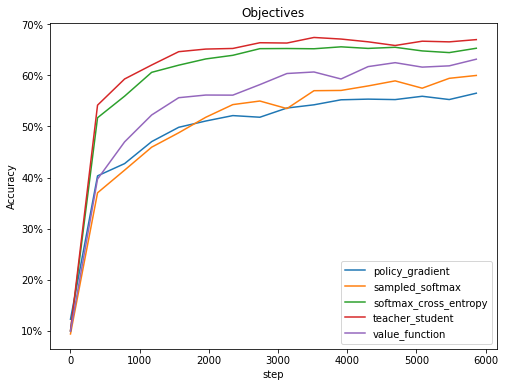

In [6]:
##########################################
# Analysis

log = L.logs.glob(str(OUT / "*.jsonl.gz")).apply(L.ops.header("name"), L.ops.count("step"))
plt.figure(figsize=(8, 6))
for color, (name, df) in zip(sns.color_palette(), log["test"].to_pandas().groupby("name")):
    df.plot(x="step", y="accuracy", color=color, label=name, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
plt.gca().set_ylabel("Accuracy")
plt.title("Objectives");

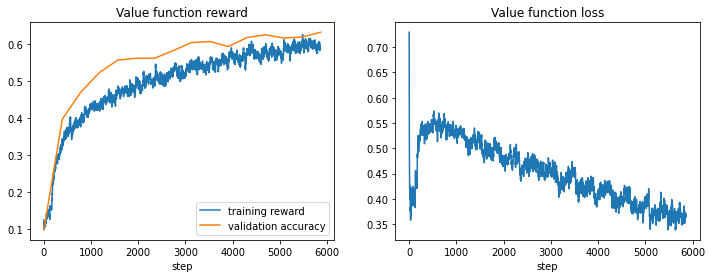

In [7]:
log = L.logs.open(OUT / "value_function.jsonl.gz").apply(L.ops.count("step"))
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
log["step"].to_pandas().ewm(com=10).mean().plot(x="step", y="reward", label="training reward", ax=ax0)
log["test"].to_pandas().plot(x="step", y="accuracy", label="validation accuracy", ax=ax0)
ax0.set_title("Value function reward")
log["step"].to_pandas().ewm(com=10).mean().plot(x="step", y="loss", ax=ax1, legend=False)
ax1.set_title("Value function loss");

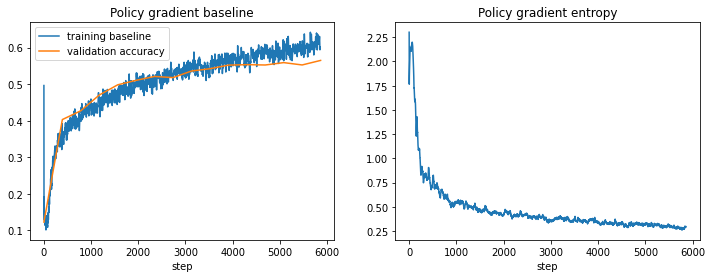

In [8]:
log = L.logs.open(OUT / "policy_gradient.jsonl.gz").apply(L.ops.count("step"))
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
log["step"].to_pandas().ewm(com=10).mean().plot(x="step", y="baseline", label="training baseline", ax=ax0)
log["test"].to_pandas().plot(x="step", y="accuracy", label="validation accuracy", ax=ax0)
ax0.set_title("Policy gradient baseline")
log["step"].to_pandas().ewm(com=10).mean().plot(x="step", y="entropy", ax=ax1, legend=False)
ax1.set_title("Policy gradient entropy");